# Kernel Density Estimation

*Kernel density estimation* (KDE) is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density.
In this section, we will explore the motivation and uses of KDE.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating KDE: Histograms

As already discussed, a density estimator is an algorithm which seeks to model the probability distribution that generated a dataset.
For one dimensional data, you are probably already familiar with one simple density estimator: the histogram.
A histogram divides the data into discrete bins, counts the number of points that fall in each bin, and then visualizes the results in an intuitive manner.

For example, let's create some data that is drawn from two normal distributions:

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

We have previously seen that the standard count-based histogram can be created with the ``plt.hist()`` function.
By specifying the ``normed`` parameter of the histogram, we end up with a normalized histogram where the height of the bins does not reflect counts, but instead reflects probability density:

<ipython-input-19-1350a8746689>:1: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  hist = plt.hist(x, bins=30, normed=True)


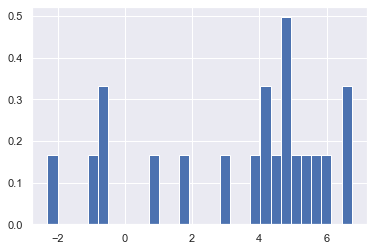

In [19]:
hist = plt.hist(x, bins=30, normed=True)

Notice that for equal binning, this normalization simply changes the scale on the y-axis, leaving the relative heights essentially the same as in a histogram built from counts.
This normalization is chosen so that the total area under the histogram is equal to 1, as we can confirm by looking at the output of the histogram function:

In [11]:
density, bins, patches = hist
# print(density, bins)
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

One of the issues with using a histogram as a density estimator is that the choice of bin size and location can lead to representations that have qualitatively different features.
For example, if we look at a version of this data with only 20 points, the choice of how to draw the bins can lead to an entirely different interpretation of the data!
Consider this example:

In [13]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)      # Set bins    


[-5.         -3.33333333 -1.66666667  0.          1.66666667  3.33333333
  5.          6.66666667  8.33333333 10.        ]


In [ ]:
print(bins)
print(bins + 0.6)

<ipython-input-14-72c490550bf5>:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax[i].hist(x, bins=bins + offset, normed=True)
<ipython-input-14-72c490550bf5>:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax[i].hist(x, bins=bins + offset, normed=True)


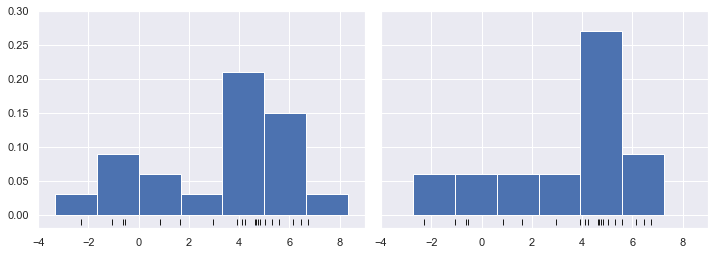

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim':(-4, 9),
                                   'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution.
On the right, we see a unimodal distribution with a long tail.
Without seeing the preceding code, you would probably not guess that these two histograms were built from the same data: with that in mind, how can you trust the intuition that histograms confer?
And how might we improve on this?

Stepping back, we can think of a histogram as a stack of blocks, where we stack one block within each bin on top of each point in the dataset.
Let's view this directly:

(-0.2, 8)

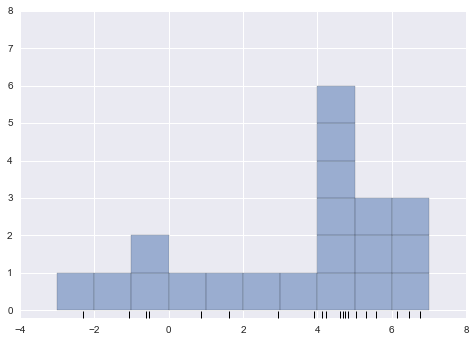

In [ ]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

The problem with our two binnings stems from the fact that the height of the block stack often reflects not on the actual density of points nearby, but on coincidences of how the bins align with the data points.
This mis-alignment between points and their blocks is a potential cause of the poor histogram results seen here.
But what if, instead of stacking the blocks aligned with the *bins*, we were to stack the blocks aligned with the *points they represent*?
If we do this, the blocks won't be aligned, but we can add their contributions at each location along the x-axis to find the result.
Let's try this:

In [20]:
x

array([ 1.62434536, -0.61175641, -0.52817175, -1.07296862,  0.86540763,
       -2.3015387 ,  6.74481176,  4.2387931 ,  5.3190391 ,  4.75062962,
        6.46210794,  2.93985929,  4.6775828 ,  4.61594565,  6.13376944,
        3.90010873,  4.82757179,  4.12214158,  5.04221375,  5.58281521])

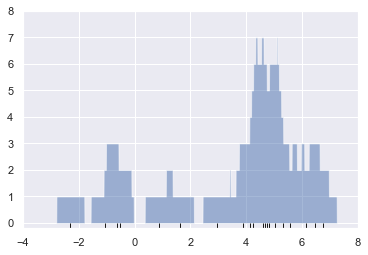

In [23]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)
# print(density)


# density = []
# for xi in x:
#     points_in_band = abs(xi - x_d) < 0.5       # bandwidth within 0.5
#     density_for_xi = sum(points_in_band)
#     density.append(density_for_xi)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

The result looks a bit messy, but is a much more robust reflection of the actual data characteristics than is the standard histogram.
Still, the rough edges are not aesthetically pleasing, nor are they reflective of any true properties of the data.
In order to smooth them out, we might decide to replace the blocks at each location with a smooth function, like a Gaussian.
Let's use a standard normal curve at each point instead of a block:

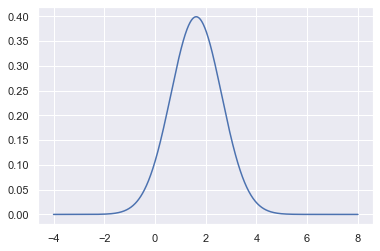

In [33]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

xi = x[0]
pdf = norm(xi).pdf(x_d)
# pdf.shape
plt.plot(x_d, pdf)


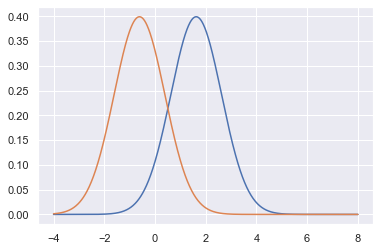

In [34]:
plt.plot(x_d, norm(x[0]).pdf(x_d))
plt.plot(x_d, norm(x[1]).pdf(x_d))

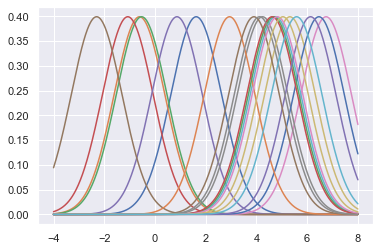

In [35]:
for xi in x:
    plt.plot(x_d, norm(xi).pdf(x_d))

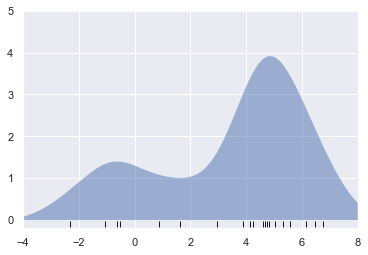

In [36]:
# density = []
# for xi in x:
#     points_with_norm = norm(xi).pdf(x_d)         # bandwidth within 0.5
#     density_for_xi = sum(points_with_norm)
#     density.append(density_for_xi)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

This smoothed-out plot, with a Gaussian distribution contributed at the location of each input point, gives a much more accurate idea of the shape of the data distribution, and one which has much less variance (i.e., changes much less in response to differences in sampling).

These last two plots are examples of kernel density estimation in one dimension: the first uses a so-called "tophat" kernel and the second uses a Gaussian kernel.
We'll now look at kernel density estimation in more detail.

## Kernel Density Estimation in Practice

The free parameters of kernel density estimation are the *kernel*, which specifies the shape of the distribution placed at each point, and the *kernel bandwidth*, which controls the size of the kernel at each point.
In practice, there are many kernels you might use for a kernel density estimation: in particular, the Scikit-Learn KDE implementation supports one of six kernels, which you can read about in Scikit-Learn's [Density Estimation documentation](http://scikit-learn.org/stable/modules/density.html).

While there are several versions of kernel density estimation implemented in Python (notably in the SciPy and StatsModels packages), I prefer to use Scikit-Learn's version because of its efficiency and flexibility.
It is implemented in the ``sklearn.neighbors.KernelDensity`` estimator, which handles KDE in multiple dimensions with one of six kernels and one of a couple dozen distance metrics.
Because KDE can be fairly computationally intensive, the Scikit-Learn estimator uses a tree-based algorithm under the hood and can trade off computation time for accuracy using the ``atol`` (absolute tolerance) and ``rtol`` (relative tolerance) parameters.
The kernel bandwidth, which is a free parameter, can be determined using Scikit-Learn's standard cross validation tools as we will soon see.

Let's first show a simple example of replicating the above plot using the Scikit-Learn ``KernelDensity`` estimator:

(-0.02, 0.22)

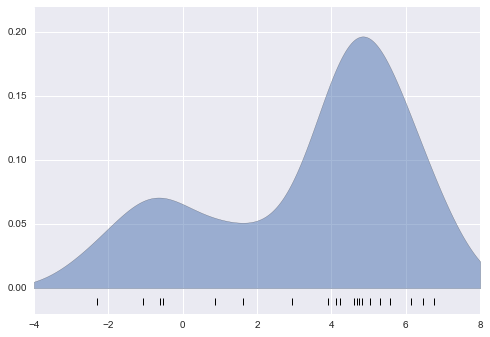

In [ ]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')

kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

The result here is normalized such that the area under the curve is equal to 1.

### Selecting the bandwidth via cross-validation

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate, and is the knob that controls the bias–variance trade-off in the estimate of density: too narrow a bandwidth leads to a high-variance estimate (i.e., over-fitting), where the presence or absence of a single point makes a large difference. Too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) where the structure in the data is washed out by the wide kernel.

There is a long history in statistics of methods to quickly estimate the best bandwidth based on rather stringent assumptions about the data: if you look up the KDE implementations in the SciPy and StatsModels packages, for example, you will see implementations based on some of these rules.

In machine learning contexts, we've seen that such hyperparameter tuning often is done empirically via a cross-validation approach.
With this in mind, the ``KernelDensity`` estimator in Scikit-Learn is designed such that it can be used directly within the Scikit-Learn's standard grid search tools.
Here we will use ``GridSearchCV`` to optimize the bandwidth for the preceding dataset.
Because we are looking at such a small dataset, we will use leave-one-out cross-validation, which minimizes the reduction in training set size for each cross-validation trial:

In [ ]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

Now we can find the choice of bandwidth which maximizes the score (which in this case defaults to the log-likelihood):

In [ ]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

The optimal bandwidth happens to be very close to what we used in the example plot earlier, where the bandwidth was 1.0 (i.e., the default width of ``scipy.stats.norm``).